In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)  # This sets all random seeds in keras
tf.config.experimental.enable_op_determinism()  # For complete reproducibility

In [3]:
def prepare_sequence_data(df):
    """Convert sequences to integer encoding"""
    alphabet = 'ARNDCQEGHILKMFPSTWYV-'
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    
    sequences = df['sequence'].values
    encodings = []
    
    for seq in sequences:
        try:
            integer_encoded = [char_to_int[char] for char in seq]
            encodings.append(integer_encoded)
        except Exception as e:
            print(f"Error processing sequence: {e}")
            continue
    
    return np.array(encodings)

In [4]:
def create_sequence_model():
    """Create CNN model for sequence data"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(33,)),
        tf.keras.layers.Embedding(21, 21, input_length=33),
        tf.keras.layers.Reshape((33, 21, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(17, 3), activation='relu', padding='valid'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [5]:
def train_and_evaluate():
    # Load data
    print("Loading data...")
    train_df = pd.read_csv("../new/processed_data_train.csv")
    test_df = pd.read_csv("../new/processed_data_test.csv")
    
    # Print class distribution
    print("Class Distribution:")
    print(train_df['label'].value_counts())
    
    # Print train and test set sizes
    print(f"Train set size: {len(train_df)}")
    print(f"Test set size: {len(test_df)}")
    
    # Shuffle the training data
    train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Prepare sequence data
    print("Preparing sequence data...")
    X_train_seq = prepare_sequence_data(train_df)
    X_test_seq = prepare_sequence_data(test_df)
    
    y_train = train_df['label'].values
    y_test = test_df['label'].values
    
    print(f"\nTraining data shape: {X_train_seq.shape}")
    print(f"Test data shape: {X_test_seq.shape}")
    
    # Calculate class weights
    total_samples = len(y_train)
    pos_samples = np.sum(y_train == 1)
    neg_samples = np.sum(y_train == 0)
    
    class_weights = {
        0: total_samples / (2 * neg_samples),
        1: total_samples / (2 * pos_samples)
    }
    
    print("\nClass weights:", class_weights)
    
    # Initialize cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Initialize metrics storage
    metrics = {'acc': [], 'mcc': [], 'sn': [], 'sp': []}
    test_predictions = []
    
    # Cross-validation loop
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_seq), 1):
        print(f"\nFold {fold}/5")
        
        # Create callbacks
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
        
        # Create and compile model
        model = create_sequence_model()
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Train model
        print("Training model...")
        history = model.fit(
            X_train_seq[train_idx], y_train[train_idx],
            batch_size=32,
            epochs=50,
            validation_data=(X_train_seq[val_idx], y_train[val_idx]),
            callbacks=[early_stopping],
            class_weight=class_weights,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Model Accuracy - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        # plt.savefig(f'accuracy_fold_{fold}.png')
        # plt.close()
        
        # Evaluate on validation set
        y_pred = model.predict(X_train_seq[val_idx])
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate metrics
        cm = confusion_matrix(y_train[val_idx], y_pred_binary)
        metrics['acc'].append(accuracy_score(y_train[val_idx], y_pred_binary))
        metrics['mcc'].append(matthews_corrcoef(y_train[val_idx], y_pred_binary))
        metrics['sn'].append(cm[1][1]/(cm[1][1]+cm[1][0]))
        metrics['sp'].append(cm[0][0]/(cm[0][0]+cm[0][1]))
        
        # Predict on test set
        test_pred = model.predict(X_test_seq)
        test_predictions.append(test_pred)
        
        print(f"\nFold {fold} Results:")
        print(f"Accuracy: {metrics['acc'][-1]:.4f}")
        print(f"MCC: {metrics['mcc'][-1]:.4f}")
        print(f"Sensitivity: {metrics['sn'][-1]:.4f}")
        print(f"Specificity: {metrics['sp'][-1]:.4f}")
    
    # Print average cross-validation results
    print("\nAverage Cross-validation Results:")
    for metric in metrics:
        print(f"{metric.upper()}: {np.mean(metrics[metric]):.4f} ± {np.std(metrics[metric]):.4f}")
    
    # Ensemble predictions on test set
    test_pred_avg = np.mean(test_predictions, axis=0)
    test_pred_binary = (test_pred_avg > 0.5).astype(int)
    
    # Calculate final test metrics
    cm_test = confusion_matrix(y_test, test_pred_binary)
    print("\nFinal Test Set Results:")
    print(f"Accuracy: {accuracy_score(y_test, test_pred_binary):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, test_pred_binary):.4f}")
    print(f"Sensitivity: {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):.4f}")
    print(f"Specificity: {cm_test[0][0]/(cm_test[0][0]+cm_test[0][1]):.4f}")
    print("Confusion Matrix:")
    print(cm_test)
    
    return model

Loading data...
Class Distribution:
label
1    4591
0    4259
Name: count, dtype: int64
Train set size: 8850
Test set size: 2737
Preparing sequence data...

Training data shape: (8850, 33)
Test data shape: (2737, 33)

Class weights: {0: 1.0389762855130311, 1: 0.9638423001524722}

Fold 1/5


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-26 21:52:23.421736: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-26 21:52:23.421761: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-26 21:52:23.421767: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-26 21:52:23.421784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-26 21:52:23.421796: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Training model...
Epoch 1/50


2024-11-26 21:52:24.560256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


222/222 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.5227 - loss: 0.6925 - val_accuracy: 0.5893 - val_loss: 0.6759
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6215 - loss: 0.6488 - val_accuracy: 0.6684 - val_loss: 0.6117
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7002 - loss: 0.5854 - val_accuracy: 0.6864 - val_loss: 0.5767
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7301 - loss: 0.5489 - val_accuracy: 0.7096 - val_loss: 0.5542
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7504 - loss: 0.5205 - val_accuracy: 0.7085 - val_loss: 0.5499
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7645 - loss: 0.5104 - val_accuracy: 0.7186 - val_loss: 0.5414
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7677 - loss: 0.4959 - val_accuracy: 0.7175 - val_loss: 0.5390
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7791 - loss: 0.4829 - val_accuracy: 0.72

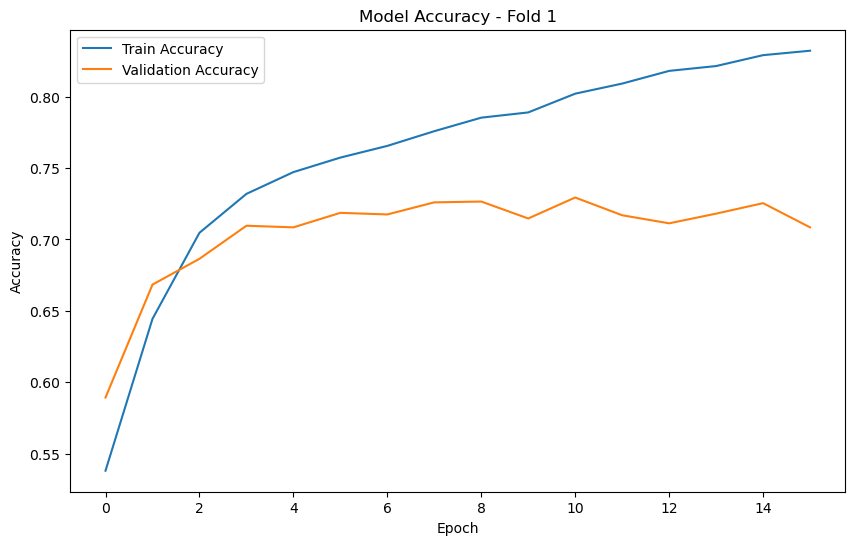

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 1 Results:
Accuracy: 0.7294
MCC: 0.4585
Sensitivity: 0.7220
Specificity: 0.7382

Fold 2/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.5207 - loss: 0.6915 - val_accuracy: 0.6073 - val_loss: 0.6530
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.6506 - loss: 0.6305 - val_accuracy: 0.6706 - val_loss: 0.6009
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7069 - loss: 0.5707 - val_accuracy: 0.7243 - val_loss: 0.5428
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7413 - loss: 0.5215 - val_accuracy: 0.7373 - val_loss: 0.5339
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.7675 - loss: 0.5013 - val_accuracy: 0.7424 - val_loss: 0.5243
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7765 - loss: 0.4807 - val_accuracy: 0.7407 - val_loss: 0.5229
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7815 - loss: 0.4680 - val_accuracy: 0.7390 - val_loss: 0.5305
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.7873 - loss: 0.4549 - val_accuracy: 0.742

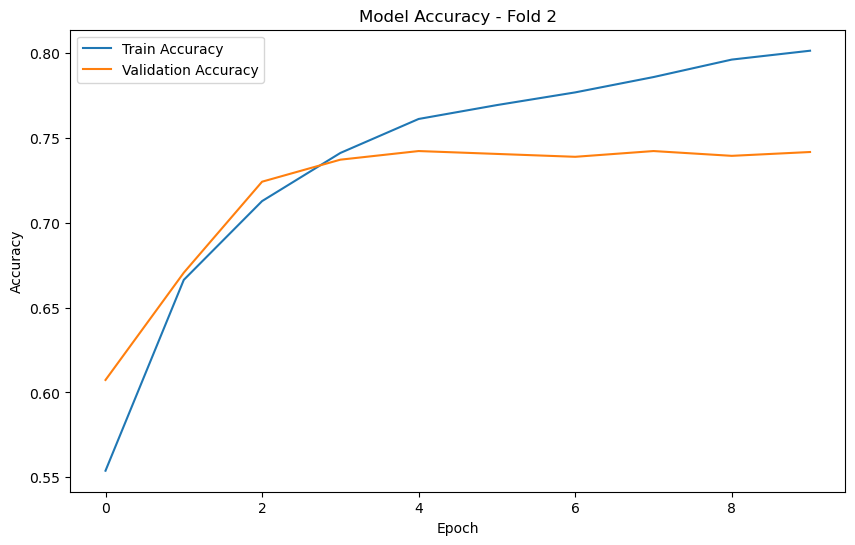

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 2 Results:
Accuracy: 0.7424
MCC: 0.4902
Sensitivity: 0.8723
Specificity: 0.5952

Fold 3/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4998 - loss: 0.6939 - val_accuracy: 0.5955 - val_loss: 0.6820
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6212 - loss: 0.6563 - val_accuracy: 0.6740 - val_loss: 0.6001
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7092 - loss: 0.5737 - val_accuracy: 0.7119 - val_loss: 0.5587
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7312 - loss: 0.5454 - val_accuracy: 0.7220 - val_loss: 0.5480
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7528 - loss: 0.5233 - val_accuracy: 0.7282 - val_loss: 0.5404
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7632 - loss: 0.5128 - val_accuracy: 0.7407 - val_loss: 0.5310
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7691 - loss: 0.4989 - val_accuracy: 0.7384 - val_loss: 0.5306
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.7764 - loss: 0.4883 - val_accuracy: 0.749

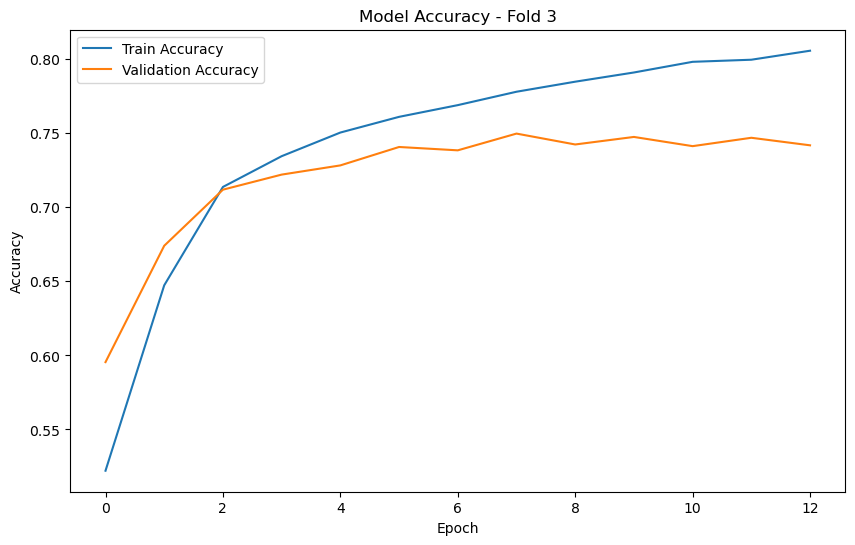

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 3 Results:
Accuracy: 0.7497
MCC: 0.5088
Sensitivity: 0.8511
Specificity: 0.6465

Fold 4/5
Training model...
Epoch 1/50


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


222/222 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5284 - loss: 0.6871 - val_accuracy: 0.6486 - val_loss: 0.6369
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6688 - loss: 0.6177 - val_accuracy: 0.6977 - val_loss: 0.5885
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7078 - loss: 0.5697 - val_accuracy: 0.7294 - val_loss: 0.5471
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7368 - loss: 0.5310 - val_accuracy: 0.7305 - val_loss: 0.5361
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7483 - loss: 0.5132 - val_accuracy: 0.7390 - val_loss: 0.5317
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7578 - loss: 0.4955 - val_accuracy: 0.7328 - val_loss: 0.5351
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7712 - loss: 0.4805 - val_accuracy: 0.7463 - val_loss: 0.5288
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7823 - loss: 0.4687 - val_accuracy: 0.735

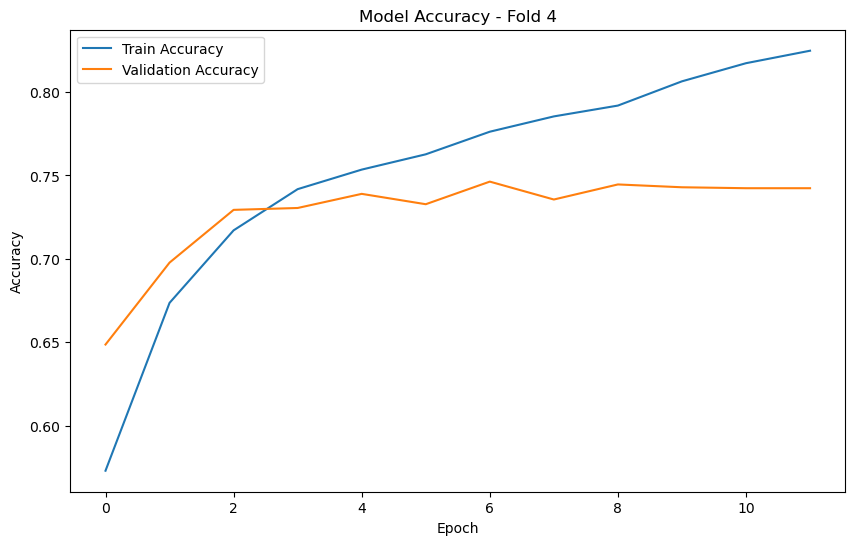

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Fold 4 Results:
Accuracy: 0.7463
MCC: 0.5045
Sensitivity: 0.8498
Specificity: 0.6442

Fold 5/5
Training model...


/Users/hai/miniconda3/envs/bioinf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.5155 - loss: 0.6921 - val_accuracy: 0.6294 - val_loss: 0.6538
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6417 - loss: 0.6380 - val_accuracy: 0.7056 - val_loss: 0.5810
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7070 - loss: 0.5722 - val_accuracy: 0.7311 - val_loss: 0.5490
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7295 - loss: 0.5386 - val_accuracy: 0.7350 - val_loss: 0.5389
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7545 - loss: 0.5184 - val_accuracy: 0.7322 - val_loss: 0.5352
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7569 - loss: 0.5028 - val_accuracy: 0.7356 - val_loss: 0.5340
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7635 - loss: 0.4976 - val_accuracy: 0.7350 - val_loss: 0.5291
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7735 - loss: 0.4844 - val_accu

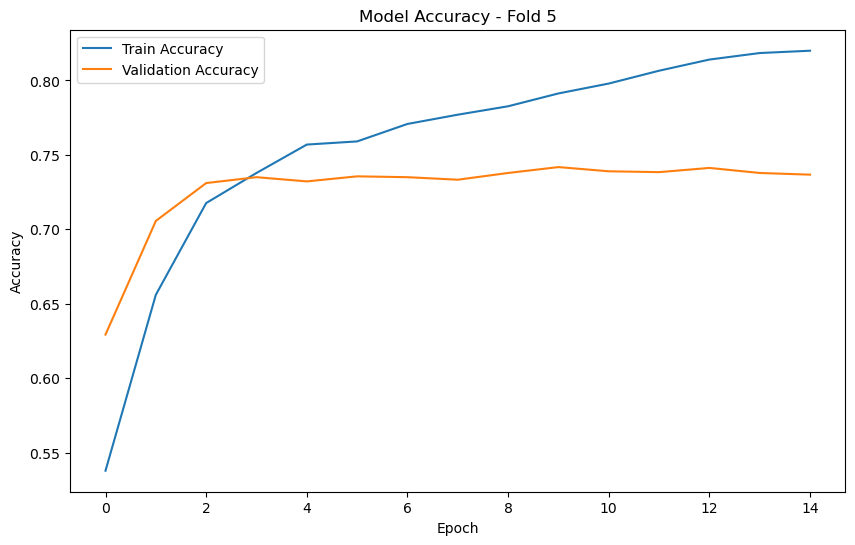

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Fold 5 Results:
Accuracy: 0.7418
MCC: 0.4842
Sensitivity: 0.8055
Specificity: 0.6737

Average Cross-validation Results:
ACC: 0.7419 ± 0.0069
MCC: 0.4892 ± 0.0178
SN: 0.8201 ± 0.0537
SP: 0.6596 ± 0.0468

Final Test Set Results:
Accuracy: 0.6708
MCC: 0.2940
Sensitivity: 0.8542
Specificity: 0.6532
Confusion Matrix:
[[1631  866]
 [  35  205]]


In [6]:
if __name__ == "__main__":
    model = train_and_evaluate()